In [52]:
import os
import pickle
import json

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn_pandas import DataFrameMapper

from feature_engine.selection import DropFeatures
from sklearn.base import BaseEstimator, TransformerMixin
import transformers_and_utilities as t
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, OrdinalEncoder

from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor

from sklearn.pipeline import Pipeline
import xgboost

import matplotlib.pyplot as plt

Config

In [53]:
LEVELS = {'HIGH': [0, 12, 18, 21, 20, 22, 19, 23, 17, 15],
         'MED': [16, 14, 1, 2, 13, 11, 10, 9, 3, 8],
         'LOW': [4, 7, 5, 6]}

ONTARIO_HOLIDAYS = [1, 46, 92, 144, 182, 249, 284, 359, 360]
SEASONS = {
     "winter": [354, 77], 
     "spring":  [78, 170],
     "summer": [171, 264],
     "fall": [265, 353]
    }

FEATURES = ['occurrencehour',
  'Pub_Id',
  'Park_Id',
  'PS_Id',
  'premises_type',
  'occurrencemonth',
  'occurrencedayofweek',
  'MCI',
  'Neighbourhood',
  'occurrenceday',
  'occurrencedayofyear']
TARGETS = ['Long', 'Lat']

In [62]:
data = pd.read_csv('raw_data_plus_new_features.csv')
data = data.drop_duplicates(subset=['event_unique_id']).reset_index()
data.dropna(inplace=True)

In [63]:
X = data[FEATURES]
y = data[TARGETS]

In [64]:
X = t.ReplaceNSA().fit_transform(X, y)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=data['Neighbourhood'],
                                                   shuffle=True,
                                                    test_size=0.2,
                                                   random_state=0)

In [66]:
mci_pipeline = Pipeline([
    ('add_weekday/weekend', t.WeekdayTransformer()),
    ('add_ToD_crime_level', t.ToDTransformer(levels=LEVELS)),
    ('add_seasons', t.SeasonTransformer(seasons=SEASONS)),
    ('add_holidays', t.HolidayTransformer(holidays=ONTARIO_HOLIDAYS)),
    ('OHE', OneHotEncoder(sparse=False)),
    ('PCA', PCA(n_components=0.95, svd_solver='full')),
    ('linear_regression', LinearRegression())
                        ])

In [67]:
mci_pipeline.fit(X_train, y_train);

In [68]:
from sklearn.metrics import mean_squared_error, r2_score

# make predictions for the train set
pred = mci_pipeline.predict(X_train)

# determine mse, rmse and r2
print('train mse: {}'.format(
    mean_squared_error((y_train), (pred))))
print('train rmse: {}'.format(
    mean_squared_error((y_train), (pred), squared=False)))
print('train r2: {}'.format(
    r2_score((y_train), (pred))))
print()

# make predictions for the test set
pred = mci_pipeline.predict(X_test)

# determine mse, rmse and r2
print('test mse: {}'.format(
    mean_squared_error((y_test), (pred))))
print('test rmse: {}'.format(
    mean_squared_error((y_test), (pred), squared=False)))
print('test r2: {}'.format(
    r2_score((y_test), (pred))))
print()


error_in_meters = ((((pred[:, 0] - y_test.iloc[:, 0])**2 + 
                     (pred[:, 1] - y_test.iloc[:, 1])**2)**0.5).mean()) * 111139
print(f"""The average prediction error is {error_in_meters} 
      meters off the actual crime location using Euclidean distance.""")

train mse: 0.00010462354781258122
train rmse: 0.010103482955806467
train r2: 0.9810674987289538

test mse: 0.00011063251605171377
test rmse: 0.010371861379940554
test r2: 0.9802512825978178

The average prediction error is 964.839084303294 
      meters off the actual crime location using Euclidean distance.


In [69]:
# measure error in Haversine distance which is more suitable for geospatial data

d = pd.DataFrame(np.concatenate((pred, y_test), axis=1, dtype="float64"))
d.columns = ["lat1","long1","lat2","long2"]
print("Crime locations predictions are about", 
      round(t.haversine_distance(d, "lat1","long1","lat2", "long2").mean(),2),
      "meters off on average using Haversine distance.")

Crime locations predictions are about 706.32 meters off on average using Haversine distance.


Checking the distribution of our errors reveals that they are normally distributed with some degree of kurtosis.

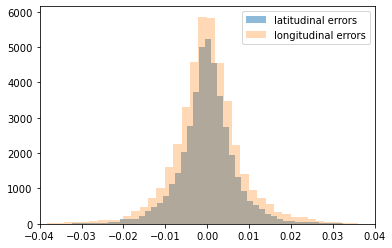

In [80]:
lat_errors = pd.Series(y_test.iloc[:,1] - pred[:,1])
long_errors = pd.Series(y_test.iloc[:,0] - pred[:,0])

fig, ax = plt.subplots()
ax.hist(x=lat_errors,bins=500, alpha=0.5, label='latitudinal errors')
ax.hist(x=long_errors,bins=500, alpha=0.3, label='longitudinal errors')
ax.set_xlim(left=-0.04, right=0.04)
ax.legend()